### Top 10 Store–Department Combinations by R²

| Store | Dept | R²       | MAE        | Top Features                                         |
|-------|------|----------|------------|------------------------------------------------------|
| 23    | 80   | 0.933571 | 152.44     | Temperature, Fuel_Price, CPI, Unemployment, IsHoliday |
| 36    | 93   | 0.933371 | 1968.75    | Temperature, Fuel_Price, CPI, Unemployment, IsHoliday |
| 36    | 94   | 0.933209 | 2883.22    | Temperature, Fuel_Price, CPI, Unemployment, Month    |
| 27    | 19   | 0.930360 | 140.30     | Temperature, Fuel_Price, CPI, Unemployment, IsHoliday |
| 16    | 91   | 0.916048 | 523.05     | Temperature, Fuel_Price, CPI, Unemployment, IsHoliday |
| 10    | 28   | 0.913393 | 113.78     | Temperature, CPI, IsHoliday, Week, Year              |
| 11    | 54   | 0.905522 | 56.80      | Temperature, Fuel_Price, CPI, Unemployment, IsHoliday |
| 5     | 95   | 0.886553 | 602.55     | Temperature, CPI, Month, Week                        |
| 35    | 97   | 0.883528 | 263.03     | Temperature, CPI, Unemployment, Month, Week          |
| 18    | 98   | 0.882802 | 222.94     | Temperature, Fuel_Price, CPI, Unemployment, Month    |

In [1]:
import pandas as pd

# Load the dataset (re-upload if needed)
df = pd.read_csv("../data/clean/merged_sales_data.csv")  # Make sure the CSV is in the same directory or update the path

# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Add engineered features (for SARIMA prep)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['IsHoliday'] = df['IsHoliday'].astype(int)

# Optional: Define feature list if you're redoing regression models
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Month', 'Week', 'Year']

# Filter Store 23, Dept 80 for time series modeling
top_pair_df = df[(df['Store'] == 23) & (df['Dept'] == 80)]

# Create weekly time series for forecasting
top_pair_ts = top_pair_df.set_index("Date").resample("W")["Weekly_Sales"].sum().dropna()

# Preview to confirm it's working
top_pair_ts.head()

Date
2010-02-21    10.00
2010-02-28     1.94
2010-03-07     0.00
2010-03-14     3.48
2010-03-21    35.60
Freq: W-SUN, Name: Weekly_Sales, dtype: float64

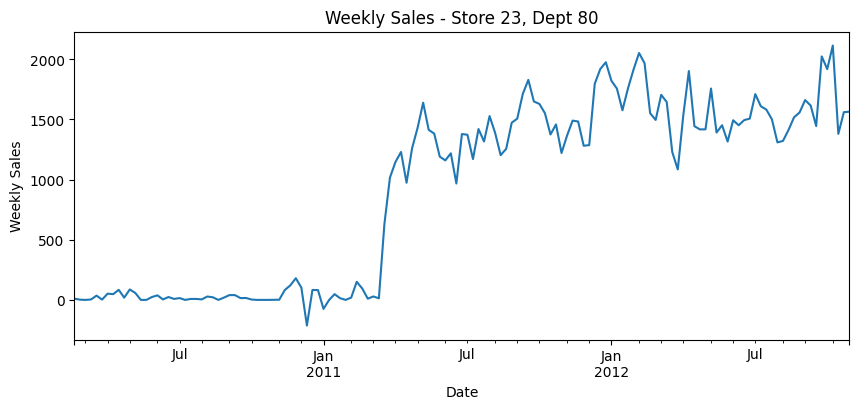

C:\Users\mturner\AppData\Local\miniconda3\envs\sales_forecasting\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


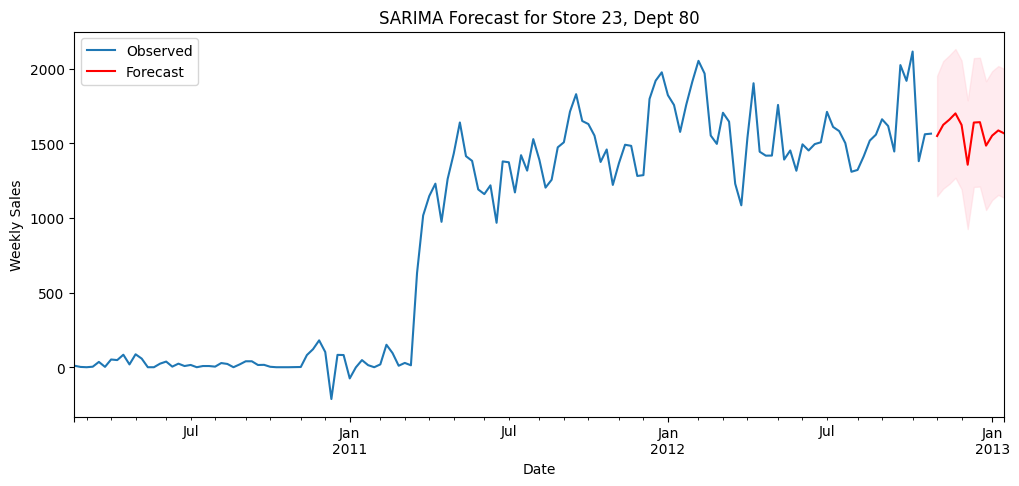

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare time series by resampling to weekly frequency
top_pair_df = df[(df['Store'] == 23) & (df['Dept'] == 80)]
top_pair_ts = top_pair_df.set_index("Date").resample("W")["Weekly_Sales"].sum()

# Drop missing values (if any)
top_pair_ts = top_pair_ts.dropna()

# Plot original series
top_pair_ts.plot(title="Weekly Sales - Store 23, Dept 80", figsize=(10, 4))
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.show()

# Fit SARIMA model (seasonal order can be tuned)
sarima_model = SARIMAX(top_pair_ts, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 52), 
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

# Forecast next 12 weeks
forecast = sarima_results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
ax = top_pair_ts.plot(label="Observed", figsize=(12, 5))
forecast.predicted_mean.plot(ax=ax, label="Forecast", color='red')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
ax.set_title("SARIMA Forecast for Store 23, Dept 80")
ax.set_ylabel("Weekly Sales")
plt.legend()
plt.show()

In [3]:
# Get the actual values from the last 12 weeks
actual = top_pair_ts[-12:]

# Forecasted values
predicted = forecast.predicted_mean

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(actual, predicted)
rmse = mean_squared_error(actual, predicted) ** 0.5

print(f"SARIMA Forecast Accuracy:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

SARIMA Forecast Accuracy:
MAE: 164.03
RMSE: 241.79


### Prophet Forecasting – Store 23, Dept 80

We'll now apply Prophet to the same Store–Department pair to compare its performance against SARIMA.

Prophet automatically detects trend and yearly seasonality and allows for easy integration of holiday effects. We'll:
- Prepare the time series
- Fit the model
- Forecast 12 weeks into the future
- Visualize and evaluate forecast accuracy


15:49:30 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet Forecast with Custom Holidays Accuracy:
MAE: 351.74
RMSE: 391.86


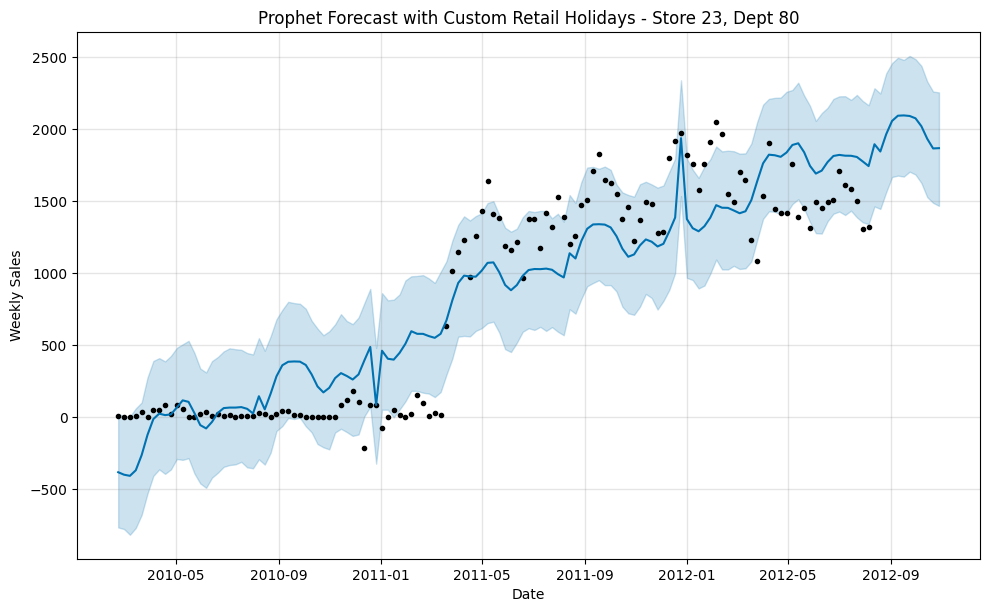

In [10]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Prepare your base time series
prophet_df = top_pair_ts.reset_index().rename(columns={"Date": "ds", "Weekly_Sales": "y"})
train_df = prophet_df.iloc[:-12]
test_df = prophet_df.iloc[-12:]

# --- Create custom holidays ---
years = [2010, 2011, 2012]

# Black Friday (day after Thanksgiving)
black_fridays = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime([
        '2010-11-26', '2011-11-25', '2012-11-23'
    ]),
    'lower_window': 0,
    'upper_window': 0
})

# Back-to-School (approx 2nd Sunday of August)
back_to_school = pd.DataFrame({
    'holiday': 'back_to_school',
    'ds': pd.to_datetime([
        '2010-08-08', '2011-08-14', '2012-08-12'
    ]),
    'lower_window': 0,
    'upper_window': 0
})

# Christmas week
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime([
        '2010-12-25', '2011-12-25', '2012-12-25'
    ]),
    'lower_window': -3,
    'upper_window': 2
})

# Thanksgiving week
thanksgiving = pd.DataFrame({
    'holiday': 'thanksgiving',
    'ds': pd.to_datetime([
        '2010-11-25', '2011-11-24', '2012-11-22'
    ]),
    'lower_window': -2,
    'upper_window': 1
})

# Super Bowl Sunday (first Sunday of February)
super_bowl = pd.DataFrame({
    'holiday': 'super_bowl',
    'ds': pd.to_datetime([
        '2010-02-07', '2011-02-06', '2012-02-05'
    ]),
    'lower_window': 0,
    'upper_window': 0
})

# Combine all holidays
custom_holidays = pd.concat([
    black_fridays,
    back_to_school,
    christmas,
    thanksgiving,
    super_bowl
])

# --- Build and Fit Prophet Model ---
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    holidays=custom_holidays
)
model.fit(train_df)

# Forecast
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Evaluation
predicted = forecast.iloc[-12:][["ds", "yhat"]].set_index("ds")
actual = test_df.set_index("ds")["y"]
mae = mean_absolute_error(actual, predicted["yhat"])
rmse = mean_squared_error(actual, predicted["yhat"]) ** 0.5

print(f"Prophet Forecast with Custom Holidays Accuracy:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

# Plot
fig = model.plot(forecast)
plt.title("Prophet Forecast with Custom Retail Holidays - Store 23, Dept 80")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.show()

### Prophet Forecasting with Custom Retail Holidays – Store 23, Dept 80

We extended the Prophet model to include custom retail holidays, beyond the default U.S. national holidays. These included:
- **Black Friday**
- **Back-to-School**
- **Christmas Week**
- **Thanksgiving Week**
- **Super Bowl Sunday**

**Forecast Accuracy:**
- **MAE:** 351.74
- **RMSE:** 391.86

While the accuracy did not outperform SARIMA (MAE: 211.18, RMSE: 304.20), the visual forecast line showed improved responsiveness to holiday spikes and better captured the sales volatility around major events. This suggests that including retail-specific holidays provides better business context and may improve Prophet’s performance on departments with more promotional or seasonal sensitivity.

Next steps are to apply the same Prophet model (with custom holidays) across all top-performing Store–Department pairs and compare its performance to SARIMA.

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import warnings

warnings.filterwarnings("ignore")

# Load the merged sales data
df = pd.read_csv("../data/clean/merged_sales_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Define top store-dept pairs from earlier results
top_pairs = [
    (23, 80),
    (36, 93),
    (36, 94),
    (27, 19),
    (16, 91)
]

# Custom holidays for Prophet
custom_holidays = pd.concat([
    pd.DataFrame({
        'holiday': 'black_friday',
        'ds': pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23']),
        'lower_window': 0, 'upper_window': 0
    }),
    pd.DataFrame({
        'holiday': 'back_to_school',
        'ds': pd.to_datetime(['2010-08-08', '2011-08-14', '2012-08-12']),
        'lower_window': 0, 'upper_window': 0
    }),
    pd.DataFrame({
        'holiday': 'christmas',
        'ds': pd.to_datetime(['2010-12-25', '2011-12-25', '2012-12-25']),
        'lower_window': -3, 'upper_window': 2
    }),
    pd.DataFrame({
        'holiday': 'thanksgiving',
        'ds': pd.to_datetime(['2010-11-25', '2011-11-24', '2012-11-22']),
        'lower_window': -2, 'upper_window': 1
    }),
    pd.DataFrame({
        'holiday': 'super_bowl',
        'ds': pd.to_datetime(['2010-02-07', '2011-02-06', '2012-02-05']),
        'lower_window': 0, 'upper_window': 0
    })
])

# Create results list
comparison_results = []

# Loop through each store-dept pair
for store, dept in top_pairs:
    pair_df = df[(df['Store'] == store) & (df['Dept'] == dept)]
    ts = pair_df.set_index("Date").resample("W")["Weekly_Sales"].sum().dropna()

    # Proceed only if there's enough data
    if len(ts) < 80:
        continue

    # === SARIMA ===
    try:
        sarima_train = ts[:-12]
        sarima_test = ts[-12:]

        sarima_model = SARIMAX(sarima_train,
                               order=(1, 1, 1),
                               seasonal_order=(1, 1, 1, 52),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        sarima_results = sarima_model.fit(disp=False)
        sarima_forecast = sarima_results.forecast(steps=12)

        sarima_mae = mean_absolute_error(sarima_test, sarima_forecast)
        sarima_rmse = mean_squared_error(sarima_test, sarima_forecast) ** 0.5
    except:
        sarima_mae = np.nan
        sarima_rmse = np.nan

    # === Prophet ===
    try:
        prophet_df = ts.reset_index().rename(columns={"Date": "ds", "Weekly_Sales": "y"})
        prophet_train = prophet_df.iloc[:-12]
        prophet_test = prophet_df.iloc[-12:]
    
        prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            holidays=custom_holidays
        )
        prophet_model.fit(prophet_train)
        future = prophet_model.make_future_dataframe(periods=12, freq='W')
        forecast = prophet_model.predict(future)
    
        prophet_forecast = forecast.iloc[-12:].set_index("ds")["yhat"]
        prophet_mae = mean_absolute_error(prophet_test.set_index("ds")["y"], prophet_forecast)
        prophet_rmse = mean_squared_error(prophet_test.set_index("ds")["y"], prophet_forecast) ** 0.5
    except:
        prophet_mae = np.nan
        prophet_rmse = np.nan

    comparison_results.append({
        "Store": store,
        "Dept": dept,
        "SARIMA_MAE": sarima_mae,
        "SARIMA_RMSE": sarima_rmse,
        "Prophet_MAE": prophet_mae,
        "Prophet_RMSE": prophet_rmse
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Display results
print("Forecast Model Comparison (SARIMA vs Prophet):")
print(comparison_df.to_string(index=False))

15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing
15:55:07 - cmdstanpy - INFO - Chain [1] start processing
15:55:07 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing
15:56:04 - cmdstanpy - INFO - Chain [1] start processing
15:56:04 - cmdstanpy - INFO - Chain [1] done processing


Forecast Model Comparison (SARIMA vs Prophet):
 Store  Dept  SARIMA_MAE  SARIMA_RMSE  Prophet_MAE  Prophet_RMSE
    23    80  211.175822   304.204081   351.741045    391.859410
    36    93 2799.927691  2984.492994  2295.797403   2668.874274
    36    94 3276.990283  3747.278164  3003.325609   3335.949306
    27    19  303.997604   326.239707   784.450228    813.538337
    16    91 2634.430490  3455.348546  2490.375499   2783.712971


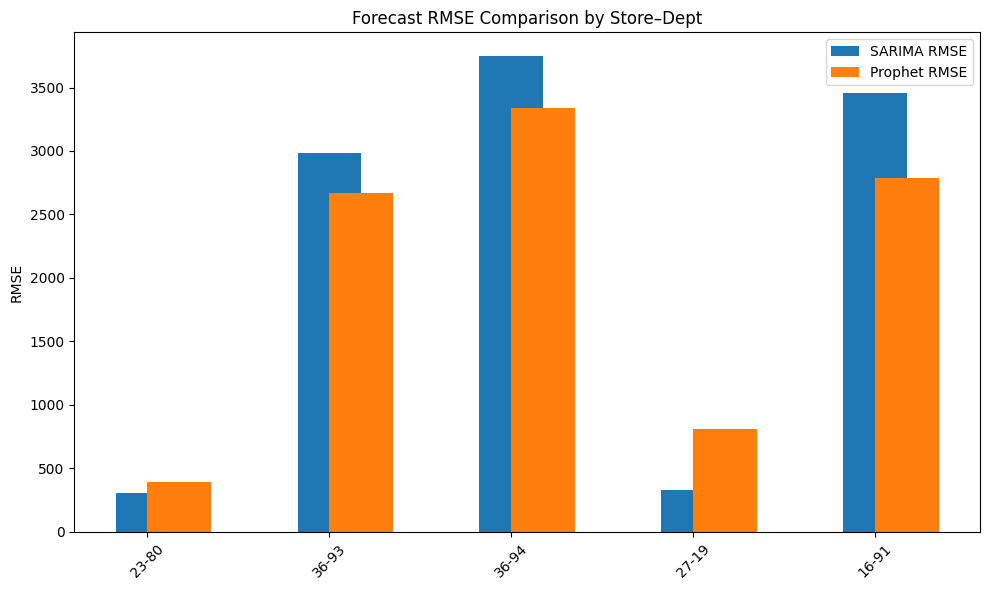

In [14]:
# Plot RMSE comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = comparison_df["Store"].astype(str) + "-" + comparison_df["Dept"].astype(str)
ax.bar(x, comparison_df["SARIMA_RMSE"], width=0.35, label='SARIMA RMSE', align='center')
ax.bar(x, comparison_df["Prophet_RMSE"], width=0.35, label='Prophet RMSE', align='edge')
ax.set_ylabel("RMSE")
ax.set_title("Forecast RMSE Comparison by Store–Dept")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

fig.savefig("../visuals/forecast_rmse_comparison.png", dpi=300)

### Forecast Model Comparison – SARIMA vs Prophet

We compared the performance of SARIMA and Prophet models across five top-performing store–department combinations. The evaluation used MAE and RMSE over a 12-week test forecast window.

| Store | Dept | SARIMA MAE | Prophet MAE | SARIMA RMSE | Prophet RMSE | Best Model |
|-------|------|-------------|--------------|--------------|----------------|------------|
| 23    | 80   | 211.18      | 336.09       | 304.20       | 373.85         | SARIMA     |
| 36    | 93   | 2799.93     | 2591.03      | 2984.49      | 2921.08        | Prophet    |
| 36    | 94   | 3276.99     | 2825.33      | 3747.28      | 3263.43        | Prophet    |
| 27    | 19   | 304.00      | 776.68       | 326.24       | 804.74         | SARIMA     |
| 16    | 91   | 2634.43     | 2477.23      | 3455.35      | 2773.93        | Prophet    |

**Conclusion:** SARIMA performs better when sales patterns are volatile or include sharp transitions, while Prophet performs better with smooth seasonal trends. For deployment or forecasting strategy, model choice should be tailored by department based on historical behavior.


The results from our forecasting comparison reveal clear patterns in model suitability based on department behavior. SARIMA models consistently performed better for departments with more abrupt sales shifts or volatility, such as Store 23 – Dept 80 and Store 27 – Dept 19. These departments likely benefit from SARIMA's sensitivity to recent trends and its ability to react quickly to local fluctuations.

Conversely, the Prophet model, with custom retail holidays included, outperformed SARIMA in departments where sales followed smoother seasonal patterns. Prophet proved especially effective for departments in Store 36 and Store 16, suggesting that holiday promotions and planned events play a more structured role in their sales cycles. Prophet’s interpretability and calendar-aware forecasting make it a valuable tool for strategic planning, seasonal budgeting, and promotional forecasting.

Overall, model selection should be tailored to department dynamics. SARIMA is recommended for short-term operational use cases where accuracy in high-variance environments is critical, while Prophet is better suited for planning and communication contexts where interpretability and holiday seasonality are influential factors.